# Uncommon Words

Here I'm trying to find words in the dictionary that are not in common usage.

To overcome OCR issues, the list of definitions is cross-references against HathiTrust's OCR for two copies of this book: only definitions in this scan that also appear in the two OCR copies are kept. This will still leaves ample definitions.

To measure "uncommon", I cross-referenced the remaining list with the 700k most common words in the HathiTrust.

In [11]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
from unusual import *
from htrc_features import FeatureReader, utils
import numpy as np
from PIL import Image

import pyocr
import pyocr.builders
tool = pyocr.get_available_tools()[0]
linebuilder = pyocr.builders.LineBoxBuilder()

path_pattern = '../data/pages/dictionary-{}.png'

In [261]:
# Open data about the book, and the Bookworm wordlist
with pd.HDFStore('./dictionary.h5', mode='r') as store:
    definitions = store['/definitions']
    allp = store['/full']
    illustrations = store['/illustrations']
    
with pd.HDFStore('/data/useful-datasets/token-frequencies/wordlist.h5', mode='r') as store:
    final = store['final']
    
definitions = definitions.groupby('word_group').filter(lambda x: (x.pagenum.max()-x.pagenum.min()) <= 1)

In [263]:
definitions[definitions.text.str.contains('QUALITY', case=False)].text

93       ABOMINABLENESS (a-bom’i-na-bI-nes). 1:. \n Qua...
131      ABSOLUTENESS (ab’so-lot-nes), 1t. Quality \n o...
139      ABSOEBABILITY (ab-sarb-a-bii’i-tl), 1!. State ...
148      ABSTEMIOUSNESS (ab-ste‘mi-us-nes), n. \n Quali...
161      ABSTRACTIVE (ab-strakt’iv), a. Having the \n p...
                               ...                        
44154    WRONGHEADEDNESS (rang’hed-ed-nes), 7!. \n Qual...
44157    WRONGNESS (rang’nes), n. 1. Quality or state \...
44163    WRYNESS (ri’nes), 1». \n Quality or state of \...
44276    YEASTINESS (yést’i-nes), ﬂ. Quality 01' state ...
44340    UCCA (ynk’a), n. \n American ever- \n green sh...
Name: text, Length: 1477, dtype: object

In [264]:
definitions[['text']].iloc[1000:1010]

,text
1009,"ALE (51), n. Liquor made from malt dried at \n..."
1010,ALECTo (a-lek’io). n. Greek .uym. One at \n th...
1011,ALEE (a-le‘). adv. Nam. At the lee side.
1012,"ALEiIBIc (a-lem'hlk), n. Apparatus formerly \n..."
1013,ALEI’PO :‘a-lep'o). 11. Town in Asiatic Turkey.
1014,"ALERT in—lert'), a. 1. Ready to act quickly: \..."
1015,"ALERT (a-lért’), n. 1. Mil. Sudden attack or \..."
1016,ALERTLY (a- ert'lil. a. In an alert manner.
1017,"ALERTNESS (a-lert‘nes), n. Quality at being \n..."
1018,"ALEXANDRIA (al-eg-zan‘dri-a), n. City in \n Eg..."


## Cull to clean words (appear in multiple OCR) and cross reference with top 700k English words

In [8]:
# Two copies of the same dictionary, Laird and Lee's Webster's. They capitalize their words, so
# I'm looking for capital words that occur in both.
paths = ['../data/loc.ark+=13960=t3xs70k06.json.bz2', '../data/loc.ark+=13960=t84j1sb5j.json.bz2']
fr = FeatureReader(paths)
tokenlist = []
for vol in fr.volumes():
    tokenlist += vol.tokens()

tokens = pd.Series(tokenlist)
# Grab capitalized letters
dictionary_words = tokens[tokens.str.contains(r"^[A-Z][A-Z\-]*$")].value_counts()
shortlist = dictionary_words[dictionary_words > 1].index.str.lower().values

In [20]:
import os
if os.path.exists('uncommonwords.csv'):
    uncommonwords = pd.read_csv('uncommonwords.csv')[0]
else:
    unique_final_lower = final['token'].str.lower().unique()
    unique_in_dicts = np.setdiff1d(shortlist, unique_final_lower[:700000])
    has_def = definitions.query('word != ""')['word'].str.lower()
    uncommonwords = pd.Series(np.intersect1d(has_def, unique_in_dicts))
    uncommonwords.sample(10)
    uncommonwords.to_csv('uncommonwords.csv', index=False)

True

## Query for definitions, and find the image

In [247]:
def query_definitions(q):
    # Remember that any query match should be expanded to the word_group
    match_groups = definitions.loc[definitions['word'] == q.upper(), "word_group"].values
    matches = definitions[definitions['word_group'].isin(match_groups.tolist())]
    return matches

match = query_definitions('dysorexy')
match

,word_group,col_group,pagenum,text,left,top,right,bottom,linenum,word,part
15250,14814,1,461,"DYSOREXY (d ’o-reks-i), n. l’athol. Bad or \n ...",669,279,1164,341,"(77, 79)",DYSOREXY,1


In [23]:
_debug = True

cellaret


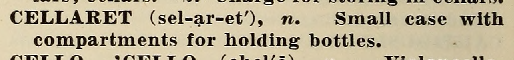

In [248]:
#for i in range(0,20):
#    word = uncommonwords.sample().values[0]
#    match = query_definitions(word)
#    img = img_from_match(match, hpad=0, wpad=0)
#    print(img.size[0])

word = uncommonwords.sample().values[0]
print(word)
match = query_definitions(word.upper())
img_from_match(match, 10, 10, _debug=_debug)

## Save all the 'Uncommon Words'

In [ ]:
!mkdir -p ../data/def_images/
i = len(uncommonwords)
for word in uncommonwords:
    match = query_definitions(word, _debug=False)
    img = img_from_match(match)
    img.save("../data/def_images/{}.png".format(word))
    i -= 1
    if i % 100 == 0:
        print(i, end=',')

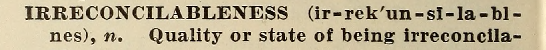

In [32]:
# Test
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)

## That's it!

### Testing: patch uncommon words into a page format

In [33]:
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageOps

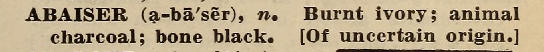

In [249]:
test_images = []
widths = []
for word in uncommonwords.values[:10]:
    match = query_definitions(word)
    img = img_from_match(match)
    w,h = img.size
    widths.append(img.size[0])
    if (w < 537) or (w > 549):
        continue
    test_images.append(img)
    widths.append(img.size[0])
test_images[0]

### Create Title Header Images

In [250]:
def get_defword_img(def_img, query):
    ''' Get just the image of the word being defined'''
    line_boxes = tool.image_to_string(def_img, lang='eng', builder=linebuilder)
    words = [(wordbox.content, wordbox.position) for box in line_boxes for wordbox in box.word_boxes]
    pos = None
    for box in line_boxes:
        for wordbox in box.word_boxes:
            if wordbox.content == query:
                pos = wordbox.position
    # Fallback: return first wordbox
    if not pos:
        pos = line_boxes[0].word_boxes[0].position
    # Trim three pixels from the bottom
    return def_img.crop(pos[0]+pos[1])

def create_img_mask(img):
    imgb = ImageEnhance.Brightness(img)
    imgc = ImageEnhance.Contrast(imgb.enhance(1.3))
    imgmask = ImageOps.invert(imgc.enhance(3).convert('L'))
    return imgmask

In [265]:
words = [('DICTIONARY', (0,0,0,0)),
         ('OFT', (0,0,13,0)),
         ('UNARM', (0,5,52,0)),
         ('USUAL', (0,0,0,0)),
         ('WORD', (0,0,0,0)),
         ('SON(', (0,1,96,0))
]
word_images = []
for word, cut_corners in words:
    match = definitions[definitions.text.str.startswith(word)][:1]
    img = img_from_match(match)
    def_img = get_defword_img(img, word)
    crop = cut_corners[:2] + ((def_img.width-cut_corners[2]), (def_img.height-cut_corners[3]))
    word_images.append(def_img.crop(crop))

titlew = sum([img.width for img in word_images]) + 30
titleh = max([img.height for img in word_images])

left = 0
title_img = Image.new('RGB', size=(titlew, titleh+2), color=(255, 255, 255))
top = [1, 1, 0, 1, 0, 0]
left_space = [10, 10, 0, 10, 0, 0]

for i, img in enumerate(word_images):
    title_img.paste(img, (left,top[i]))
    left += img.width + left_space[i]

title_img_mask = create_img_mask(title_img)
title_img

In [268]:
a = definitions.loc[36838:].head(15).copy()
a

,word_group,col_group,pagenum,text,left,top,right,bottom,linenum,word,part
36838,35759,3,1064,SOMNAMBULISM (som-nam’hu-lizm). 7». Act \n or ...,724,242,1217,324,"(82, 84)",SOMNAMBULISM,1
36839,35760,3,1064,SOMNAMBULIST (som-nam’bl‘i-list). n. One \n wh...,724,329,1216,366,"(85, 86)",SOMNAMBULIST,1
36840,35761,3,1064,"SOMNIFEEOUS (som-nif’ér-ns), a. Bringﬂng \n or...",724,373,1216,434,"(87, 89)",SOMNIFEEOUS,1
36841,35762,3,1064,"SOHINILOQ'UIST (Som-nil’D-kwlst), n. one Who \...",723,439,1215,500,"(90, 92)",,1
36842,35763,3,1064,"SOMNIUDI (som'ni-um), \n Dream. [L.]",723,505,983,544,"(93, 94)",SOMNIUDI,1
36843,35764,3,1064,"SOMNOFOEDI (som’no-farm), M. New anaes- \n the...",723,506,1216,654,"(95, 101)",SOMNOFOEDI,1
36844,35765,3,1064,SOMNOLENCE (som’no-lens). SOEINOLENCY \n (som’...,722,659,1216,764,"(102, 106)",SOMNOLENCE,1
36845,35766,3,1064,SOMNOLENT (som’no-lent); a. Inclined to \n sle...,722,769,1214,808,"(107, 108)",SOMNOLENT,1
36846,35767,3,1064,"SOliINOLISl‘I (som/nO-lizm), n. 1. State of be...",722,813,1215,874,"(109, 111)",,1
36847,35768,3,1064,"SOMNUS (som'nus), 11. Ram. Myth. God of \n sle...",722,873,1214,918,"(112, 113)",SOMNUS,1


In [267]:
a[(a.left - a.left.shift(1)).fillna(0).abs() < 10]

,word_group,col_group,pagenum,text,left,top,right,bottom,linenum,word,part
4635,4530,2,153,BIOGRAPH (bi’é-gl‘al). 11. Apparatus for \n th...,104,1006,602,1112,"(45, 49)",BIOGRAPH,1
4636,4531,2,153,"BIOGRAPHEE (bi-og’l‘a-iér), n. One who \n writ...",104,1117,601,1178,"(50, 52)",BIOGRAPHEE,1
4637,4532,2,153,"BIOGRAPHIC (hi-o—graf’lk), BIOGRAPHICAL \n (bi...",104,1183,601,1244,"(53, 55)",BIOGRAPHIC,1
4638,4533,2,153,"BIOGRAPHY (bi-og’l'a—ﬂ), n. [pL BIOG’RA- \n PH...",105,1248,601,1332,"(56, 59)",BIOGRAPHY,1
4639,4534,2,153,"BIOLOGICAL (bi-ﬁ-loj'i-kal), a. Pertaining or ...",106,1337,601,1376,"(60, 61)",BIOLOGICAL,1
4640,4535,2,153,"BIOLOGIST (bi-ol'ﬁ-Ilst), n. \n biology. \n On...",106,1381,601,1420,"(62, 66)",BIOLOGIST,1
4641,4536,2,153,"BIOLOGY (bi-ol'o-ji), n. 1. Science or life in...",106,1425,601,1487,"(67, 69)",BIOLOGY,1
4644,4539,2,153,"BIOD‘IE’I‘RY (bi-onl’e—tri), \n calculates the...",675,234,958,294,"(78, 80)",,1
4645,4540,2,153,"BION (hi’on), n. Biol. \n [Gr. Mos, life.]",674,300,918,339,"(81, 82)",BION,1
4646,4541,2,153,"BIONOMY (bi-on'ﬁ-Ini), n. Biol. That branch \n...",674,344,1168,405,"(83, 85)",BIONOMY,1


In [266]:
match

,word_group,col_group,pagenum,text,left,top,right,bottom,linenum,word,part
36848,35769,3,1064,"SON(sun),n. 1. Male offspring. 2. Male de- \n ...",721,924,1214,966,"(114, 115)",SON,1


In [273]:
match = query_definitions("SON")
img = img_from_match(match, hpad=0, wpad=0)

In [306]:
im.save('')

Signature: im.save(fp, format=None, **params)
Docstring:
Saves this image under the given filename.  If no format is
specified, the format to use is determined from the filename
extension, if possible.

Keyword options can be used to provide additional instructions
to the writer. If a writer doesn't recognise an option, it is
silently ignored. The available options are described in the
:doc:`image format documentation
<../handbook/image-file-formats>` for each writer.

You can use a file object instead of a filename. In this case,
you must always specify the format. The file object must
implement the ``seek``, ``tell``, and ``write``
methods, and be opened in binary mode.

:param fp: A filename (string), pathlib.Path object or file object.
:param format: Optional format override.  If omitted, the
   format to use is determined from the filename extension.
   If a file object was used instead of a filename, this
   parameter should always be used.
:param params: Extra parameters to the 

In [ ]:
_debug = False

save_path = '../outputs/test1/'
!mkdir -p {save_path}
margin = 45
ncols = 1
sep_margin = margin
colwidth = 494 # allp.width.value_counts().head(20).index.values.max()
par_pad = 9 # 0.5 * colwidth - allp.width.value_counts().head(20).index.values.min()
header_size = 50
footer_size = 65
wsize = int(margin*ncols + colwidth * ncols+sep_margin)
hsize = int(wsize*4/3) 
if ncols == 1:
    hsize = int(wsize/9*16) # phone screen / tik tok proportion :)
page_color = (212, 198, 168)
ink_color = (70,30,30)

# how many times to retry the fit at the bottom of a page
# likely don't want this if printing in alphabetical order, since
# it skips words, but perhaps it's worth skipping words if the
# retry threshold is high - it means the word that wouldn't fit
# was pretty large
retries = 5 
retry_threshold = 10 # how much space left to warrant a retry

vplace_start = margin + header_size + 20

# Add images
vplace = vplace_start
column = 0
page_num = 1

im = Image.new('RGB', (wsize, hsize), color=page_color)
draw = ImageDraw.Draw(im)
font = ImageFont.truetype("../fonts/Sahitya-Regular.ttf", 25)

retries_left = retries

def add_header(im):
    im.paste(title_img,
             (int((wsize-title_img.width)/2), int(margin)),
            title_img_mask)

def add_page_num(im):
    if page_num > 0:
        numw, numh = draw.textsize(str(page_num)) 
        draw.text(((wsize)/2-numw, 
                   int(hsize-footer_size*0.6-numh)
                  ), str(page_num), font=font, fill="black")

def add_vdividers(im):
    # Add vertical divider, sampled from scans
    for sep in range(1, ncols):
        div = img_from_match(allp.query("(left > 614) & (left < 635) & (text == '') & (height < 1450) "
                                        "& (height > 1400) and (width < 5)").sample(1))
        div = div.resize((div.width, hsize-header_size-margin-footer_size-20), Image.ANTIALIAS)
        im.paste(div, 
                 (int(sep*(wsize-div.width)/ncols), int(header_size + margin + 10)),
                 create_img_mask(div))

def add_hdivider(im):
    # Add horizontal lines at the top and bottom, sampled from scans
    wide_lines = allp.query("(text == '') & (width < 1060) & (width > 1030) and (height < 5)").sample(2)
    header_hr = img_from_match(wide_lines[:1])
    header_hr = header_hr.resize((int(header_hr.width/2*ncols), header_hr.height), Image.ANTIALIAS)
    im.paste(header_hr, (int((wsize-header_hr.width)/2), int(margin + header_size - (header_hr.height)/2)), create_img_mask(header_hr))

    footer_hr = img_from_match(wide_lines[1:2])
    footer_hr = footer_hr.resize((int(footer_hr.width/2*ncols), footer_hr.height), Image.ANTIALIAS)
    im.paste(footer_hr, (int((wsize-footer_hr.width)/2), int(hsize-footer_size+(footer_hr.height)/2)), create_img_mask(footer_hr))
    
def add_decor(im):
    add_header(im)
    add_page_num(im)
    add_vdividers(im)
    add_hdivider(im)
    
for word in uncommonwords.values:
    match = query_definitions(word)
    if (match.top > match.bottom).any():
        continue
    if (match.left > match.right).any():
        continue
    
    img = img_from_match(match, hpad=0, wpad=0)
    w,h = img.size

    if (w > colwidth+5):
        print(f"'{word}' too wide: {w}px (max {colwidth+5})")
        continue
    elif (w < colwidth-15) & (h > 50):
        # If it's an under-width definition, create a version with an
        # illustration next it
        img_w_illust = Image.new('RGB', (colwidth, h),
                                  color=((255,0,0) if _debug else (255,255,255)))
        illust = Image.new('RGB', (colwidth-w-10, h),
                           color=((0,255,0) if _debug else (255,255,255)))
        img_w_illust.paste(img, (0, 0))
        img_w_illust.paste(illust, (w+10, 0))
        img = img_w_illust
        
    if (vplace+h) > (hsize-footer_size-10):
        if retries_left & (hsize-footer_size-10-vplace > retry_threshold):
            retries_left -= 1
            print(f'skipping {word}; vplace is {vplace}')
            continue
            
        vplace = vplace_start
        if column < ncols:
            column += 1
            retries_left = retries
        else:
            add_decor(im)
            if save_path:
                im.save(save_path + f'/dictionary.{page_num}.png')
                pass
            print(f"Moving on to page {page_num+1}")
            
            # reset vars
            column = 0
            page_num += 1
            retries_left = retries
            im = Image.new('RGB', (wsize, hsize), color=page_color)
            draw = ImageDraw.Draw(im)
    imgmask = create_img_mask(img)
    im.paste(img, (margin+(column*(colwidth+sep_margin)), vplace), imgmask)
    
    # If at the top of a column, add column header
    if vplace == vplace_start:
        word = match.word.values[0]
        def_img = get_defword_img(img, word)
        def_img_mask = create_img_mask(def_img)
        im.paste(def_img,
                 (int((colwidth-def_img.width)/2+margin+(column*(colwidth+sep_margin))), 
                  int(margin+header_size-def_img.height-10)),
                def_img_mask)
        
    vplace += (h + par_pad)

add_decor(im)
im.resize((int(wsize/ncols),int(hsize/ncols)), Image.ANTIALIAS)

'abama' too wide: 857px (max 499)
skipping accountably; vplace is 928
Moving on to page 2
skipping acrisius; vplace is 952
Moving on to page 3
skipping adosculation; vplace is 940
'advertence' too wide: 504px (max 499)
skipping adytum; vplace is 874
'aerify' too wide: 512px (max 499)
Moving on to page 4
skipping agiotage; vplace is 739
Moving on to page 5
skipping air-hole; vplace is 826
skipping alienability; vplace is 949
Moving on to page 6
'aliped' too wide: 971px (max 499)
skipping allegorize; vplace is 908
'alpenstock' too wide: 513px (max 499)
skipping altercate; vplace is 952
Moving on to page 7
skipping amenableness; vplace is 941
skipping amylacetate; vplace is 902
Moving on to page 8
skipping angel-food; vplace is 951
Moving on to page 9
'answerableness' too wide: 514px (max 499)
Moving on to page 10
skipping anthropophagous; vplace is 933
skipping antiscians; vplace is 901
Moving on to page 11
'aphengescope' too wide: 670px (max 499)
Moving on to page 12
'appeaser' too wide

In [341]:
(definitions.top > definitions.bottom).sum()

7

In [338]:
definitions.loc[43037:].head(15)

,word_group,col_group,pagenum,text,left,top,right,bottom,linenum,word,part
43037,41814,1,1230,"VITUI'ERATION (vi-tu-pér-E’shun), n. \n vitupe...",149,1131,554,1171,"(48, 49)",,1
43038,41815,1,1230,VIVA Cvé’vii). interj. Long live! Often used s...,149,1175,638,1216,"(50, 51)",VIVA,1
43039,41816,1,1230,"VIVACIOL'S (vi—vﬁ’shus), a. Lively; active; \n...",149,1219,637,1259,"(52, 53)",,1
43040,41817,1,1230,"VIVACIOIZSLY (vi-vi’sliuS-li), ad'u, \n cious ...",149,1262,514,1302,"(54, 55)",VIVACIOIZSLY,1
43041,41818,1,1230,"VIVACIOUSNESS (ti-vi’sllus-ucs), n. Same as \n...",148,1306,637,1343,"(56, 57)",VIVACIOUSNESS,1
43042,41819,1,1230,"VIVACITY (vi-vas’i—ti), n. Livollness of man- ...",148,1350,638,1394,"(58, 59)",VIVACITY,1
43043,41820,1,1230,"VIVANDIERE (vi-véng-dyﬁr’), n. Female \n sutle...",148,1393,637,1432,"(60, 61)",VIVANDIERE,1
43044,41821,1,1230,VIVARIUDI (vi-vft’ri-Ilm). n. Place Where livi...,148,1436,639,1498,"(62, 70)",VIVARIUDI,1
43045,41821,2,1230,In a viva-,534,1265,639,1280,"(72, 72)",,2
43046,41822,2,1230,"VLADIVOSTUK (viii-dE-V'ﬁs—tﬁk’), n.",704,999,1099,1021,"(74, 74)",VLADIVOSTUK,1


In [337]:
match

,word_group,col_group,pagenum,text,left,top,right,bottom,linenum,word,part
43047,41823,2,1230,VIVERRINE (vi-ver’in). n. A carnivorous ani- \...,711,1025,1204,293,"(75, 77)",VIVERRINE,1


In [335]:
allp.sort_values('width', ascending=False).head(20)

,,pagenum,linenum,text,left,top,right,bottom,ignore,width,height,def_start,coldiff,possible_pic,possible_caption,word_group,col_group
501,156,538,156,,0,0,1266,126,True,1266,126,False,-1216.0,False,False,17656,0
393,136,428,136,,0,0,1266,1789,True,1266,1789,False,-452.0,False,False,13809,0
237,134,264,134,,0,0,1266,1789,True,1266,1789,False,-462.0,False,False,8395,0
399,132,434,132,,0,0,1266,1789,True,1266,1789,False,-436.0,False,False,14018,0
239,132,268,132,,0,0,1266,1789,True,1266,1789,False,-426.0,False,False,8470,0
575,159,612,159,,0,1515,1266,1789,True,1266,274,False,-1260.0,False,False,20354,0
397,135,432,135,,0,0,1266,1789,True,1266,1789,False,-427.0,False,False,13948,0
241,132,270,132,,0,0,1266,1789,True,1266,1789,False,-430.0,False,False,8533,0
243,135,274,135,,0,0,1266,1789,True,1266,1789,False,-411.0,False,False,8601,0
395,157,430,157,,0,1531,1266,1789,True,1266,258,False,-1248.0,False,False,13876,0


In [192]:
allp.query("(text == '') & (width < 1060) & (width > 1030) and (height < 30)").width.value_counts().head(20)

1051    196
1052    182
1050    141
1053    141
1049    136
1048    112
1054     85
1047     81
1046     73
1045     70
1044     54
1043     40
1042     28
1041     24
1040     22
1055     20
1034     18
1037     17
1031     16
1039     14
Name: width, dtype: int64

In [186]:
allp.query("(text == '') & (height < 1450) "
                                "& (height > 1400) and (width < 10)").left.value_counts().head(20)

629    23
625    17
617    17
632    16
683    16
627    16
626    16
630    15
621    15
679    14
680    13
685    13
682    13
615    13
619    13
695    12
675    12
634    12
614    11
622    11
Name: left, dtype: int64

In [182]:
allp.query("(text == '') & (height < 1750) & (width < 10)").height.value_counts().head(20)

9       224
4       168
3       128
13      113
10       95
5        90
2        83
1413     83
1415     81
12       78
1412     70
1414     66
1417     65
1411     60
1418     55
1416     55
1419     49
8        43
22       41
11       40
Name: height, dtype: int64

# TODO
- Add illustrations next to narrower definitions
- Add illustrations about the last definition in a column, if there is too much space

In [ ]:
_debug = not _debug

In [ ]:
# Section: One who or that
definitions[definitions.word.str.endswith('ER') & definitions.text.str.contains('one.*or that', case=False)]

,word_group,col_group,pagenum,left,text,right,linenum,top,bottom,word,part
355,344,0,41,195,"ADAPTER (a-dap’tér), n. 1. One who or that \n ...",790,"(12, 15)",332,433,ADAPTER,1
445,429,2,44,246,"ADOPTER (a-dopt’er), n. One who or that \n whi...",834,"(29, 30)",736,783,ADOPTER,1
1148,1117,3,63,868,"AMBLER (am’hlér), n. One who or that which \n ...",1466,"(75, 76)",233,276,AMBLER,1
1223,1190,4,66,899,"AMPLIFIER (am’pli-ﬁ-ér), n. One who or that \n...",1496,"(85, 86)",323,370,AMPLIFIER,1
1300,1266,2,68,237,"ANALYZER (an’a-li’z'ér), n. One who or that \n...",825,"(62, 64)",1569,1639,ANALYZER,1
1895,1840,6,84,251,"APPLIER (ap-pli’ér), n. One who or that which ...",841,"(58, 60)",1149,1227,APPLIER,1
2491,2419,3,106,900,"ATODIIZER (at’um-i—zér), \n n. One who or that...",1239,"(79, 84)",354,508,ATODIIZER,1
2572,2496,4,108,913,"ATTRACTER (at-trakt’i‘r), ATTRACTOR (at- \n tl...",1506,"(115, 116)",1196,1241,ATTRACTER,1
2983,2896,3,123,869,"BAFFLER (baf’lér), n. One who or that which \n...",1461,"(129, 130)",1576,1615,BAFFLER,1
3015,2926,2,125,182,"BAITER (bat’ér), n. One who or that which \n b...",776,"(20, 21)",429,472,BAITER,1
